This exercise consists in analyzing a <mark>dataset containg timing information from a series</mark> of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the <mark>type of message</mark> ('HEAD', which in this case is always 1), <mark>two addresses of the TDC providing the signal</mark> ('FPGA' and 'TDC_CHANNEL'), and the <mark>timing information</mark>('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [4]:
# If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

In [5]:
import numpy as np
import pandas as pd

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [6]:
# input file
filename = "data/data_000637.txt"

# input all data
data = pd.read_csv(filename)

# read from file first 20k rows (header excluded)
df = pd.read_csv(filename, nrows=20000)
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
19995,1,0,27,3869200366,2513,29
19996,1,0,63,3869200366,2517,6
19997,1,0,32,3869200366,2519,5
19998,1,0,17,3869200366,2522,21


2\. Estimate the number of BX in a ORBIT (the value 'x').

In [7]:
'''
    I chose to carry out the exercise
    with the whole dataset.
'''

# description of the dataset
data.describe()

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
count,1310720.0,1.310720e+06,1.310720e+06,1.310720e+06,1.310720e+06,1.310720e+06
mean,1.0,2.959198e-01,5.582570e+01,3.869206e+09,1.781096e+03,1.332340e+01
std,0.0,4.564553e-01,3.901034e+01,3.183124e+03,1.027795e+03,9.199886e+00
min,1.0,0.000000e+00,1.000000e+00,3.869200e+09,0.000000e+00,0.000000e+00
25%,1.0,0.000000e+00,2.600000e+01,3.869203e+09,8.930000e+02,5.000000e+00
50%,1.0,0.000000e+00,5.700000e+01,3.869207e+09,1.778000e+03,1.300000e+01
75%,1.0,1.000000e+00,6.400000e+01,3.869209e+09,2.670000e+03,2.100000e+01
max,1.0,1.000000e+00,1.390000e+02,3.869211e+09,3.563000e+03,2.900000e+01


In [8]:
'''
    We can find 'x' (the number of BX_COUNTER
    necessary to increase the ORBIT_CNT by 1) by increasing the 
    maximum BX_COUNTER by one unit, given that the maximum 
    value is reached in the data set.
'''

x = np.max(data['BX_COUNTER']) + 1 
print( "The value of ORBIT_CNT is increased every", x, "BX_COUNTER" )

The value of ORBIT_CNT is increased every 3564 BX_COUNTER


3\. Find out the duration of the data taking in hours, minutes and seconds. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading the whole dataset.

In [9]:
time = ( 25 / 30 ) * data['TDC_MEAS'] + 25 * data['BX_COUNTER'] + 25 * x * data['ORBIT_CNT']
acqTime = np.max(time) - np.min(time)

print( "The duration of the data taking is:", acqTime, "ns or", acqTime / 1e9, "s" )

The duration of the data taking is: 980416253.3125 ns or 0.9804162533125 s


4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition.

In [11]:
'''
    I assume that 'absolute time' refers to scaling
    the time with respect to the first entry.
'''

# starting time
t0 = ( 25 / 30 ) * data.iat[0,5] + 25 * data.iat[0,4] + 25 * x * data.iat[0,3]

# create the column with scaling
data['TIME_NS'] = time - t0
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_NS
0,1,0,123,3869200167,2374,26,0.000000e+00
1,1,0,124,3869200167,2374,27,8.125000e-01
2,1,0,63,3869200167,2553,28,4.476625e+03
3,1,0,64,3869200167,2558,19,4.594125e+03
4,1,0,64,3869200167,2760,25,9.649125e+03
...,...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14,9.804161e+08
1310716,1,1,4,3869211171,763,11,9.804161e+08
1310717,1,0,64,3869211171,764,0,9.804161e+08
1310718,1,0,139,3869211171,769,0,9.804163e+08


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [12]:
'''
    To retrieve the noisiest channels, first group by
    TDC_CHANNEL and get counts. Then, sort values and
    get the tail of the output dataset.
'''

noisyCh = df.groupby('TDC_CHANNEL').count().sort_values('HEAD').tail(3)
noisyCh

,HEAD,FPGA,ORBIT_CNT,BX_COUNTER,TDC_MEAS
TDC_CHANNEL,,,,,
63,969,969,969,969,969
64,996,996,996,996,996
139,1693,1693,1693,1693,1693


6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit). Count also the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [13]:
# number of non-empty orbits
g1 = data.groupby('ORBIT_CNT')
print("The number of non-empty orbits is", len(g1))

# number of unique orbits with at least one meas from TDC_CHANNEL=139
g2 = data[data['TDC_CHANNEL'] == 139].groupby('ORBIT_CNT')
print("The second number is", len(g2))

The number of non-empty orbits is 11001
The second number is 10976


7\. **Optional:** Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

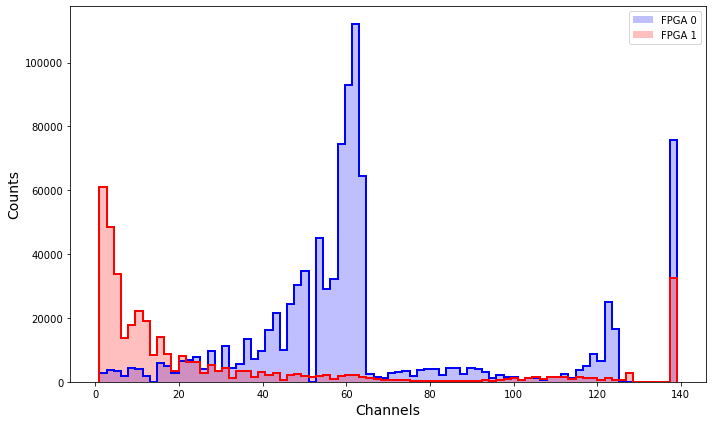

In [16]:
# datasets
d1 = data[data['FPGA'] == 0]
d2 = data[data['FPGA'] == 1]

# plot (transparent filling and edges)
plt.hist(d1.loc[:,'TDC_CHANNEL'], bins=80, histtype="stepfilled", label="FPGA 0", facecolor="blue", alpha=0.25)
plt.hist(d2.loc[:,'TDC_CHANNEL'], bins=80, histtype="stepfilled", label="FPGA 1", facecolor="red", alpha=0.25)
plt.hist(d1.loc[:,'TDC_CHANNEL'], bins=80, histtype="step", edgecolor="blue", linewidth=2)
plt.hist(d2.loc[:,'TDC_CHANNEL'], bins=80, histtype="step", edgecolor="red", linewidth=2)

# set labels and legend
plt.xlabel("Channels", fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.legend(loc="upper right")

# adjust figure size
figure = plt.gcf()
figure.set_size_inches(10, 6)
plt.tight_layout()

plt.show()